70. 単語ベクトルの和による特徴量Permalink

In [27]:
import json
import re
import random
import pandas as pd
from sklearn.model_selection import train_test_split
# データの読込
df=pd.read_csv('NewsAggregatorDataset/newsCorpora.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
#df[df['PUBLISHER']  == 'Reuters']
df = df[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]
df = df[['TITLE','CATEGORY']]

#分割はlist、ndarray、DataFrame

train,valid_once=train_test_split(df,test_size=0.2,shuffle=True,random_state=100,stratify=df['CATEGORY'])
valid,test=train_test_split(valid_once,test_size=0.5,shuffle=True,random_state=100,stratify=valid_once['CATEGORY'])

In [28]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('~/Desktop/ニューラル勉強会/hlab2023-nlp100/7/GoogleNews-vectors-negative300.bin', binary=True)

In [29]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
import torch
import torch.nn as nn

In [30]:
def processing(data):
    x=[]
    y=[]
    label={'b':0,'t':1,'e':2,'m':3}
    for title,categoly in data:
        table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        title = title.translate(table)  # 記号をスペースに置換
        title = re.sub('[0-9]+','0',title)
        title = title.lower()
        title = title.split()
        vec = [model[word] for word in title if word in model]
        x.append(sum(vec) / len(vec))
        y.append(label[categoly])
    return torch.tensor(x),torch.tensor(y)

train = np.array(train)
valid = np.array(valid)
test  = np.array(test)

x_train, y_train = processing(train)
x_valid, y_valid = processing(valid)
x_test , y_test  = processing(test)

torch.Size(x_train.size())
print(x_train)
print(y_train)


tensor([[-0.0200,  0.1468, -0.1442,  ..., -0.0660,  0.0160,  0.1448],
        [-0.0325,  0.0205,  0.0668,  ..., -0.0393,  0.0037, -0.0476],
        [ 0.0546, -0.0825, -0.0760,  ..., -0.0602,  0.0048, -0.0069],
        ...,
        [-0.0367,  0.0171, -0.0423,  ..., -0.0434,  0.0469,  0.0620],
        [ 0.0225,  0.0613,  0.0038,  ..., -0.0829, -0.0349, -0.0185],
        [-0.0289,  0.0737, -0.0573,  ..., -0.0636,  0.0144,  0.1008]])
tensor([2, 0, 1,  ..., 0, 2, 2])


71. 単層ニューラルネットワークによる予測

In [31]:
class SLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)   #正規乱数で重みを初期化
        #↑なくても問題ない，なんでいる？（無いとmodel(train)は均一に近い値になる）
    
    def forward(self, x):
        logits = self.fc(x)
        return logits

In [32]:
torch.manual_seed(1)
#model = SLPNet(300, 4)
#わざわざSLNetを作る意味とは
model = nn.Linear(300, 4)
nn.init.normal_(model.weight, 0.0, 1.0)   #正規乱数で重みを初期化

print(model(x_train[:1]))
#そもそもマイナスに対してどうやってsoftmaxしてるのか不明

#model()でも呼び出されるのはforward
#なるべくforwardを直接使用するのは避ける
y_hat_1 = torch.softmax(model(x_train[:1]), dim=-1)
#dimとは→-2,0で列単位-1,1で行単位，なんで二個あるのかは知らん
print(y_hat_1)
Y_hat = torch.softmax(model(x_train[:4]), dim=-1)
print(Y_hat)

tensor([[-1.0368,  1.7777,  0.8214,  0.5145]], grad_fn=<AddmmBackward0>)
tensor([[0.0347, 0.5790, 0.2225, 0.1637]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0347, 0.5790, 0.2225, 0.1637],
        [0.1497, 0.4886, 0.2236, 0.1380],
        [0.0493, 0.3584, 0.3407, 0.2516],
        [0.1980, 0.2933, 0.1872, 0.3215]], grad_fn=<SoftmaxBackward0>)


72. 損失と勾配の計算

In [33]:
criterion = nn.CrossEntropyLoss()

In [34]:
l_1 = criterion(model(x_train[:1]), y_train[:1])
#入力ベクトルはsoftmax前の値
#softmax後の値を入れたら，勾配が計算できなかった

model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.weight.grad}')

損失: 1.5027
勾配:
tensor([[-0.0007,  0.0051, -0.0050,  ..., -0.0023,  0.0006,  0.0050],
        [-0.0116,  0.0850, -0.0835,  ..., -0.0382,  0.0093,  0.0838],
        [ 0.0156, -0.1141,  0.1121,  ...,  0.0513, -0.0124, -0.1125],
        [-0.0033,  0.0240, -0.0236,  ..., -0.0108,  0.0026,  0.0237]])


73. 確率的勾配降下法による学習

In [35]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]

In [36]:
from torch.utils.data import DataLoader

dataset_train = NewsDataset(x_train, y_train)
dataset_valid = NewsDataset(x_valid, y_valid)
dataset_test = NewsDataset(x_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)
#DataLoaderに必要なのは，Datasetオブジェクト，バッチサイズ，シャッフル
#データセット：lenとgetitemを指定し，データへの一定のアクセス手法を提供する
#バッチサイズ：？，何回にわけるか
#シャッフル：エポックごとにデータをシャッフルするかどうか，学習はシャッフルあり，再現性の観点からtestはシャッフルなし

In [37]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

print(model.parameters)

#オプティマイザ：自動微分の結果を利用してモデルの更新を行うもの
# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)#model.parametersとはなにか

# 学習
num_epochs = 15
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()
 
  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval() 
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

<bound method Module.parameters of SLPNet(
  (fc): Linear(in_features=300, out_features=4, bias=False)
)>
epoch: 1, loss_train: 0.5262, loss_valid: 0.3993
epoch: 2, loss_train: 0.3627, loss_valid: 0.3552
epoch: 3, loss_train: 0.3321, loss_valid: 0.3417
epoch: 4, loss_train: 0.3159, loss_valid: 0.3337
epoch: 5, loss_train: 0.3049, loss_valid: 0.3316
epoch: 6, loss_train: 0.2970, loss_valid: 0.3330
epoch: 7, loss_train: 0.2919, loss_valid: 0.3251
epoch: 8, loss_train: 0.2862, loss_valid: 0.3232
epoch: 9, loss_train: 0.2833, loss_valid: 0.3219
epoch: 10, loss_train: 0.2795, loss_valid: 0.3198
epoch: 11, loss_train: 0.2775, loss_valid: 0.3219
epoch: 12, loss_train: 0.2753, loss_valid: 0.3162
epoch: 13, loss_train: 0.2735, loss_valid: 0.3190
epoch: 14, loss_train: 0.2717, loss_valid: 0.3189
epoch: 15, loss_train: 0.2698, loss_valid: 0.3172


74. 正解率の計測

In [38]:
def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return correct / total

acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.912
正解率（評価データ）：0.886


75. 損失と正解率のプロットPermalink

epoch: 1, loss_train: 0.3806, accuracy_train: 0.8695, loss_valid: 0.3817, accuracy_valid: 0.8756
epoch: 2, loss_train: 0.3328, accuracy_train: 0.8858, loss_valid: 0.3477, accuracy_valid: 0.8823
epoch: 3, loss_train: 0.3130, accuracy_train: 0.8924, loss_valid: 0.3382, accuracy_valid: 0.8853
epoch: 4, loss_train: 0.3011, accuracy_train: 0.8959, loss_valid: 0.3285, accuracy_valid: 0.8913
epoch: 5, loss_train: 0.2923, accuracy_train: 0.9005, loss_valid: 0.3239, accuracy_valid: 0.8913
epoch: 6, loss_train: 0.2870, accuracy_train: 0.9030, loss_valid: 0.3200, accuracy_valid: 0.8883
epoch: 7, loss_train: 0.2809, accuracy_train: 0.9048, loss_valid: 0.3198, accuracy_valid: 0.8906
epoch: 8, loss_train: 0.2768, accuracy_train: 0.9052, loss_valid: 0.3193, accuracy_valid: 0.8883
epoch: 9, loss_train: 0.2729, accuracy_train: 0.9074, loss_valid: 0.3180, accuracy_valid: 0.8951
epoch: 10, loss_train: 0.2704, accuracy_train: 0.9088, loss_valid: 0.3156, accuracy_valid: 0.8951
epoch: 11, loss_train: 0.2681

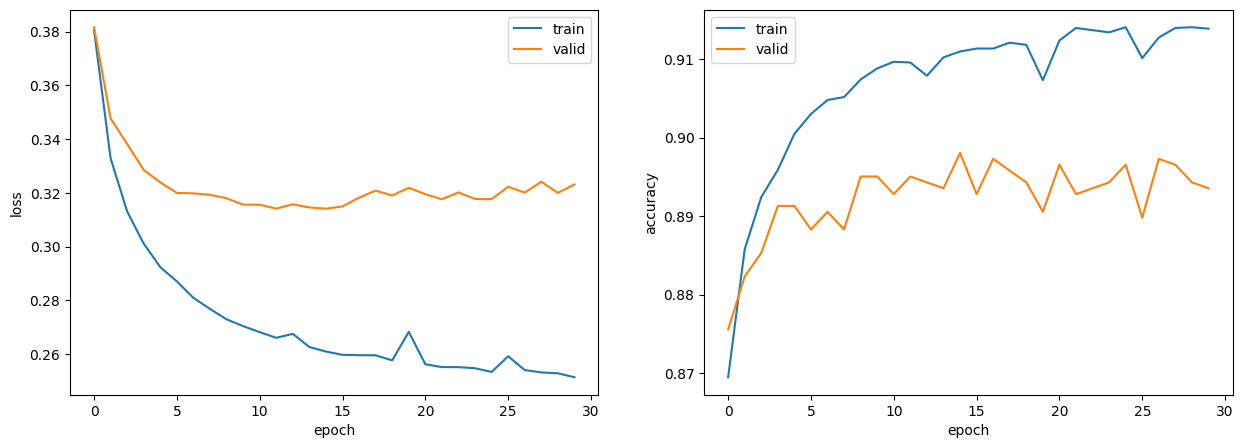

In [39]:
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}') 

from matplotlib import pyplot as plt

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

76. チェックポイントPermalink

In [40]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
 
  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 0.3896, accuracy_train: 0.8686, loss_valid: 0.3949, accuracy_valid: 0.8718
epoch: 2, loss_train: 0.3407, accuracy_train: 0.8846, loss_valid: 0.3600, accuracy_valid: 0.8808
epoch: 3, loss_train: 0.3193, accuracy_train: 0.8911, loss_valid: 0.3458, accuracy_valid: 0.8868
epoch: 4, loss_train: 0.3052, accuracy_train: 0.8945, loss_valid: 0.3385, accuracy_valid: 0.8846
epoch: 5, loss_train: 0.2953, accuracy_train: 0.9016, loss_valid: 0.3306, accuracy_valid: 0.8868
epoch: 6, loss_train: 0.2896, accuracy_train: 0.8994, loss_valid: 0.3314, accuracy_valid: 0.8883
epoch: 7, loss_train: 0.2833, accuracy_train: 0.9025, loss_valid: 0.3269, accuracy_valid: 0.8921
epoch: 8, loss_train: 0.2817, accuracy_train: 0.9047, loss_valid: 0.3288, accuracy_valid: 0.8861
epoch: 9, loss_train: 0.2753, accuracy_train: 0.9074, loss_valid: 0.3219, accuracy_valid: 0.8921
epoch: 10, loss_train: 0.2722, accuracy_train: 0.9070, loss_valid: 0.3216, accuracy_valid: 0.8921


77. ミニバッチ化

In [41]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
  
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}
# datasetの作成
dataset_train = NewsDataset(x_train, y_train)
dataset_valid = NewsDataset(x_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

#バッチサイズ1の時が性能低め，一回だけの学習ならばバッチサイズは大きい方がいい？

バッチサイズ: 1
epoch: 1, loss_train: 0.3813, accuracy_train: 0.8686, loss_valid: 0.3867, accuracy_valid: 0.8748, 0.8783sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3524, accuracy_train: 0.8788, loss_valid: 0.3620, accuracy_valid: 0.8793, 0.5396sec
バッチサイズ: 4
epoch: 1, loss_train: 0.3434, accuracy_train: 0.8833, loss_valid: 0.3552, accuracy_valid: 0.8868, 0.3286sec
バッチサイズ: 8
epoch: 1, loss_train: 0.3392, accuracy_train: 0.8855, loss_valid: 0.3525, accuracy_valid: 0.8868, 0.2422sec
バッチサイズ: 16
epoch: 1, loss_train: 0.3374, accuracy_train: 0.8862, loss_valid: 0.3511, accuracy_valid: 0.8868, 0.1497sec
バッチサイズ: 32
epoch: 1, loss_train: 0.3363, accuracy_train: 0.8866, loss_valid: 0.3505, accuracy_valid: 0.8868, 0.1011sec
バッチサイズ: 64
epoch: 1, loss_train: 0.3362, accuracy_train: 0.8870, loss_valid: 0.3503, accuracy_valid: 0.8876, 0.0788sec
バッチサイズ: 128
epoch: 1, loss_train: 0.3360, accuracy_train: 0.8870, loss_valid: 0.3502, accuracy_valid: 0.8876, 0.0696sec
バッチサイズ: 256
epoch: 1, loss_train: 0.3354, accuracy_

78. GPU上での学習

79. 多層ニューラルネットワーク